In [1]:
#hide
%matplotlib inline
import datetime

import numpy as np
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns
import arviz as az
import pymc3 as pm
import theano.tensor as tt
from sunode.wrappers.as_theano import solve_ivp
import sunode
import sympy as sym

import requests
import io

sns.set_context('talk')
plt.style.use('seaborn-whitegrid')

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [2]:
import load_covid_data

## Data

In [3]:
df_sign = load_covid_data.load_data(filter_n_days_100=10)
df_sign = df_sign[df_sign.state.isna()]

countries = pd.Series(df_sign.country.unique())
countries = countries.loc[~countries.isin(['Cruise Ship (total)', 'Cruise Ship'])]
n_countries = len(countries)
countries = countries.rename('country').to_frame().set_index('country')

In [4]:
df_sign = df_sign.reset_index()
df_sign.index.name = 'observation'

previous = (
    df_sign
    .reset_index()
    .groupby(['country'])
    .apply(
        lambda x:
        x.set_index('date')
        .assign(date=x.date.values)
        .sort_index()
        .shift()
    )
)

df_sign = (
    df_sign
    .reset_index()
    .set_index(['country', 'date'])
    .assign(
        previous_date=previous.date,
        previous_confirmed=previous.confirmed,
    )
    .reset_index()
    .set_index('observation')
)

df_sign['new_confirmed'] = df_sign.eval('confirmed - previous_confirmed')
df_sign['days_since_last_data'] = (df_sign['date'] - df_sign['previous_date']).dt.days
df_sign = df_sign.dropna(subset=['new_confirmed'])

## Growth Rate Predictions

In [5]:
pop_file = 'https://github.com/datasets/population/raw/master/data/population.csv'
populations = pd.read_csv(pop_file)
populations = populations.sort_values(['Country Name', 'Year']).groupby(['Country Name']).last()

idxs = populations.index.get_indexer([c.replace('(total)', '').strip() for c in countries.index])
countries['population'] = [populations.iloc[i].Value if idx != -1 else pd.NA for i, idx in enumerate(idxs)]

In [6]:
countries.loc['Egypt', 'population'] = populations.loc['Egypt, Arab Rep.'].Value
countries.loc['Iran', 'population'] = populations.loc['Iran, Islamic Rep.'].Value
countries.loc['Korea, South', 'population'] = populations.loc['Korea, Rep.'].Value
countries.loc['Hong Kong', 'population'] = populations.loc['Hong Kong SAR, China'].Value
countries.loc['Czechia', 'population'] = populations.loc['Czech Republic'].Value
countries.loc['US (total)', 'population'] = populations.loc['United States'].Value

In [7]:
countries['population'] = countries.population.values.astype('d')

In [8]:
multi_country = True

if multi_country:
    max_countries = 50
    countries = countries.iloc[:n_countries]
    n_countries = len(countries)
    df_sign = df_sign[df_sign.country.isin(countries.index)]
else:
    n_countries = 1
    country = 'Italy'

    countries = countries.loc[country: country]
    df_sign = df_sign[df_sign.country == country]    

In [9]:
start_day = df_sign.date.min() - datetime.timedelta(days=1)
end_data_day = df_sign.date.max()
end_day = end_data_day + datetime.timedelta(days=30)

data_time = pd.date_range(start_day, end_data_day)
time = pd.date_range(start_day, end_day)
country = countries.index

In [10]:
log_scale = False

if not log_scale:
    def sir_rhs(t, y, p):
        exp = np.vectorize(sym.exp)
        infections = exp(y.log_infection_rate) * y.S * y.I
        remissions = p.remission_rate * y.I

        change = [
            sunode.symode.lambdify.interpolate_spline(t, p.infection_change_polys[i], 0, len(data_time), degree=4)
            for i in range(len(infections))
        ]

        return {
            'S': -infections,
            'I': infections - remissions,
            'R': remissions,
            'log_infection_rate': change,
        }
else:
    def sir_rhs(t, y, p):
        exp = np.vectorize(sym.exp)
        infections = exp(y.log_infection_rate + y.I + y.S)
        remissions = p.remission_rate * exp(y.I)

        change = [
            sunode.symode.lambdify.interpolate_spline(t, p.infection_change_polys[i], 0, len(data_time), degree=4)
            for i in range(len(infections))
        ]

        return {
            'S': -infections / exp(y.S),
            'I': (infections - remissions) / exp(y.I),
            'R': remissions / exp(y.R),
            'log_infection_rate': change,
        }


with pm.Model() as model:
    log_pop = np.log(countries['population'].values)
    if multi_country:
        sd = pm.HalfNormal('init_logI_sd')
        mu = pm.Normal('init_logI_mu')
        raw = pm.Normal('init_logI_raw', shape=n_countries)
        init_logI = mu + sd * raw - log_pop
        pm.Deterministic('init_logI', init_logI)
    else:
        init_logI = pm.Normal('init_logI_raw', shape=n_countries)
        init_logI = init_logI - log_pop
        pm.Deterministic('init_logI', init_logI)

    if multi_country:
        sd = pm.HalfNormal('log_infect_sd')
        mu = pm.Normal('log_infect_mu')
        raw = pm.Normal('log_infect_raw', shape=n_countries)
        log_infect = mu + sd * raw
        pm.Deterministic('log_infect', log_infect)
    else:
        log_infect = pm.Normal('log_infect', shape=n_countries)

    if multi_country:
        sd = pm.HalfNormal('log_remiss_sd')  # In 1/day/infected
        mu = pm.Normal('log_remiss_mu')
        raw = pm.Normal('log_remiss_raw', shape=n_countries)
        log_remiss = mu + sd * raw
        pm.Deterministic('log_remiss', log_remiss)
    else:
        log_remiss = pm.Normal('log_remiss', shape=n_countries)
        
    sd = pm.HalfNormal('infection_change_polys_sd')
    raw = pm.StudentT('infection_change_polys_raw', shape=(n_countries, 8), nu=5)
    infection_change_polys = sd * raw / 100

    if not log_scale:
        init = {
            'S': (1 - tt.exp(init_logI), (n_countries,)),
            'I': (tt.exp(init_logI), (n_countries,)),
            'R': (np.zeros(n_countries), (n_countries,)),
            'log_infection_rate': (log_infect, (n_countries,)),
        }
    else:
        init = {
            'S': (tt.log1p(-tt.exp(init_logI)), (n_countries,)),
            'I': (init_logI, (n_countries,)),
            'R': np.full(n_countries, -20, dtype='d'),
            'log_infection_rate': (log_infect, (n_countries,)),
        }
    
    params = {
        #'infection_rate': (tt.exp(log_infect), (n_countries,)),
        'remission_rate': (tt.exp(log_remiss), (n_countries,)),
        'infection_change_polys': (infection_change_polys, (n_countries, 8)),
        '_placeholder': (np.zeros(n_countries), (n_countries,)),
    }
    
    solutions = []
    problems = []
    solvers = []
    for i in range(n_countries):
        init_i = {
            name: (var[i:i+1], (1, *shape_others))
            for i, (name, (var, (_, *shape_others))) in enumerate(init.items())
        }
        params_i = {
            name: (var[i:i+1], (1, *shape_others))
            for i, (name, (var, (_, *shape_others))) in enumerate(params.items())
        }
        
        solution_i, flat_solution, problem, solver, *_ = solve_ivp(
            t0=0,
            y0=init_i,
            params=params_i,
            tvals=np.arange(len(data_time)),
            rhs=sir_rhs,
            solver_kwargs={
                'solver': 'ADAMS',
                #'constraints': np.r_[np.ones(n_countries * 3), np.zeros(n_countries)],
                'constraints': np.array([1., 1, 1, 0]),
            }
        )
        problems.append(problem)
        solvers.append(solver)
        solutions.append(solution_i)
    
    solution = {}
    for name in init:
        solution[name] = tt.join(1, *[vals[name] for vals in solutions])

        
    for name in init:
        if log_scale:
            pm.Deterministic(f'solution_{name}', tt.exp(solution[name]))
        else:
            pm.Deterministic(f'solution_{name}', solution[name])

    # The number of people who have at some time been infected
    if log_scale:
        log_cases = tt.log1p(-tt.exp(solution['S'])) + np.log(countries.population.values[None, :])
    else:
        cases = (1 - solution['S']) * countries.population.values[None, :]
    #cases = solution['I'] * countries.population.values[None, :]

    idx_country = countries.index.get_indexer(df_sign.country)
    idx_data_time = data_time.get_indexer(df_sign.date)
    idx_previous_time = data_time.get_indexer(df_sign.previous_date)
    
    assert -1 not in idx_country
    assert -1 not in idx_data_time
    assert -1 not in idx_previous_time
    
    if log_scale:
        log_current_infected = log_cases[idx_data_time, idx_country]
        log_previous_infected = log_cases[idx_previous_time, idx_country]
        #mu = tt.exp(log_current_infected) - tt.exp(log_previous_infected) + 1
        mu_confirmed = tt.exp(log_current_infected)
    else:
        current_infected = cases[idx_data_time, idx_country]
        previous_infected = cases[idx_previous_time, idx_country]
        #mu = current_infected - previous_infected + 1
        mu_confirmed = current_infected
    
    alpha = pm.HalfNormal('confirmed_alpha', shape=n_countries, sd=10)
    pm.Deterministic('mu_confirmed', mu_confirmed)
    pm.NegativeBinomial(
        'confirmed_count',
        mu_confirmed,
        alpha[idx_country],
        observed=np.maximum(0, df_sign['confirmed'].values)
    )
    
    if log_scale:
        log_cases = solution['R'] + np.log(countries.population.values[None, :])
    else:
        cases = solution['R'] * countries.population.values[None, :]
    
    if log_scale:
        log_current_recovered = log_cases[idx_data_time, idx_country]
        log_previous_recovered = log_cases[idx_previous_time, idx_country]
        #mu = tt.exp(log_current_infected) - tt.exp(log_previous_infected) + 1
        mu_recovered = tt.exp(log_current_recovered)
    else:
        current_recovered = cases[idx_data_time, idx_country]
        previous_recovered = cases[idx_previous_time, idx_country]
        #mu = current_infected - previous_infected + 1
        mu_recovered = current_recovered
    
    alpha = pm.HalfNormal('recovered_alpha', shape=n_countries, sd=10)
    pm.Deterministic('mu_recovered', mu_recovered)
    pm.NegativeBinomial(
        'recovered_count',
        mu_recovered,
        alpha[idx_country],
        observed=np.maximum(0, df_sign['recovered'].values + df_sign['deaths'].values)
    )

/home/adr/anaconda3/envs/pymc/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/adr/anaconda3/envs/pymc/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


In [11]:
solutions[1]['R'].tag.test_value.shape

(57, 1)

In [12]:
cases.tag.test_value.shape

(57, 18)

In [13]:
lib = sunode._cvodes.lib

In [ ]:
    jac_prod = problem.make_sundials_jac_prod()
    lin_solver = lib.SUNLinSol_SPGMR(solver._state_buffer.c_ptr, lib.PREC_NONE, 5)
    lib.SUNLinSolInitialize_SPGMR(lin_solver)

    lib.CVodeSetLinearSolver(solver._ode, lin_solver, sunode.basic.ffi.NULL)

    lib.CVodeSetJacTimes(solver._ode, sunode.basic.ffi.NULL, jac_prod.cffi)

    jac_prod = problem.make_sundials_adjoint_jac_prod()
    lin_solverB = lib.SUNLinSol_SPGMR(solver._state_buffer.c_ptr, lib.PREC_NONE, 5)
    lib.SUNLinSolInitialize_SPGMR(lin_solverB)

    lib.CVodeSetLinearSolverB(solver._ode, solver._odeB, lin_solverB, sunode.basic.ffi.NULL)

    lib.CVodeSetJacTimesB(solver._ode, solver._odeB, sunode.basic.ffi.NULL, jac_prod.cffi)



In [14]:
for problem, solver in zip(problems, solvers):
    lib.CVodeSStolerances(solver._ode, 1e-7, 1e-7)
    lib.CVodeSStolerancesB(solver._ode, solver._odeB, 1e-6, 1e-6)
    lib.CVodeQuadSStolerancesB(solver._ode, solver._odeB, 1e-6, 1e-6)
    lib.CVodeSetMaxNumSteps(solver._ode, 500)
    lib.CVodeSetMaxNumStepsB(solver._ode, solver._odeB, 500)
    #lib.CVodeSetMinStep(solver._ode, 1e-12)
    #lib.CVodeSetMinStepB(solver._ode, solver._odeB, 1e-12)
    lib.CVodeSetMaxOrd(solver._ode, 4)
    lib.CVodeSetMaxOrdB(solver._ode, solver._odeB, 4)
    #lib.CVodeSetInitStep(solver._ode, 1e-7)
    #lib.CVodeSetInitStepB(solver._ode, solver._odeB, -1e-6)
    #lib.CVodeSetMaxStep(solver._ode, 50)
    #lib.CVodeSetMaxStepB(solver._ode, solver._odeB, 50)

In [15]:
func = model.logp_dlogp_function()
func.set_extra_values({})

In [16]:
np.random.seed(42)

In [17]:
x0 = np.random.randn(func.size)
func(x0)

/home/adr/anaconda3/envs/pymc/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


(array(-47547.31119204),
 array([-4.97753393e+03, -1.98826271e+03, -1.52161765e+00, -3.26821370e+03,
         2.34153375e-01,  2.34136957e-01, -1.57921282e+00, -7.67434729e-01,
         4.69474386e-01, -5.42560044e-01,  4.63417693e-01,  4.65729754e-01,
        -2.41962272e-01,  1.91328024e+00,  1.72491783e+00,  5.62287529e-01,
         1.01283112e+00, -3.14247333e-01,  9.08024076e-01,  1.41230370e+00,
        -1.92681031e+04, -4.00767998e+04, -6.75282047e-02,  1.42474819e+00,
         5.44382725e-01, -1.73547728e+05,  1.15099358e+00, -3.75698018e-01,
         6.00638690e-01,  2.91693750e-01,  6.01706612e-01, -1.85227818e+00,
         1.34972247e-02,  1.05771093e+00, -8.22544912e-01,  1.22084365e+00,
        -2.08863595e-01,  1.95967012e+00,  1.32818605e+00, -1.96861236e-01,
        -6.66215336e+03,  2.75131562e+04,  5.75779173e+04,  3.01103696e-01,
         1.47852199e+00,  7.19844208e-01,  4.60638771e-01, -1.05712223e+00,
        -3.43618290e-01,  1.76304016e+00, -3.24083969e-01,  3.8

In [18]:
out = sunode._cvodes.ffi.new('long[1]')
lib.CVodeGetNumNonlinSolvIters(solver._ode, out)
out[0]

150

In [19]:
%timeit func(x0)

61.5 ms ± 187 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
import theano
func_dets = theano.function(model.free_RVs, model.deterministics)
dets = {var.name: vals for var, vals in zip(model.deterministics, func_dets(**func.array_to_dict(x0)))}

In [ ]:
import theano
func_logps = theano.function(model.free_RVs, [var.logp_elemwiset for var in model.observed_RVs])
logps = {var.name: vals for var, vals in zip(model.observed_RVs, func_logps(**func.array_to_dict(x0)))}

In [ ]:
(~np.isfinite(logps['recovered_count'])).nonzero()

In [ ]:
dets['solution_R'].min()

In [ ]:
with model:
    trace = pm.sample(tune=1000, chains=6, cores=6, discard_tuned_samples=False, compute_convergence_checks=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 6 jobs)
NUTS: [recovered_alpha, confirmed_alpha, infection_change_polys_raw, infection_change_polys_sd, log_remiss_raw, log_remiss_mu, log_remiss_sd, log_infect_raw, log_infect_mu, log_infect_sd, init_logI_raw, init_logI_mu, init_logI_sd]
/home/adr/anaconda3/envs/pymc/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


In [345]:
import arviz
tr = arviz.from_pymc3(
    trace=trace,
    coords={
        'data_time': data_time,
        'country': country,
        'time': time,
        'observation': df_sign.index,
        'infection_poly': np.arange(8),
    },
    dims={
        'init_logI_raw': ['country'],
        'init_logI': ['country'],
        'log_infect_raw': ['country'],
        'log_infect': ['country'],
        'log_remiss_raw': ['country'],
        'log_remiss': ['country'],
        'solution_I': ['data_time', 'country'],
        'solution_S': ['data_time', 'country'],
        'solution_R': ['data_time', 'country'],
        'solution_log_infection_rate': ['data_time', 'country'],
        'infection_change_polys_raw': ['country', 'infection_poly'],
        'infection_change_polys': ['country', 'infection_poly'],
        'confirmed_alpha': ['country'],
        'recovered_alpha': ['country'],
        'mu_confirmed': ['observation'],
        'mu_recovered': ['observation'],
    },
    log_likelihood=False,
).posterior

In [346]:
import xarray as xr

In [347]:
xr.DataArray(countries['population'])

<xarray.DataArray 'population' (country: 5)>
array([34656032.,  2876101., 40606052.,    55599.,    77281.])
Coordinates:
  * country  (country) object 'Japan' 'Singapore' 'Germany' 'Italy' 'Sweden'

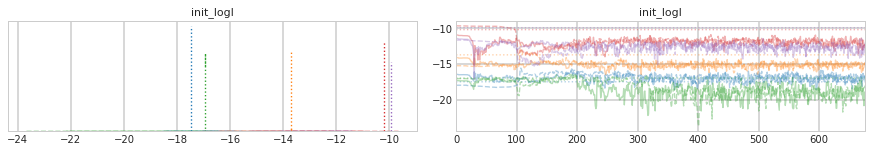

In [348]:
arviz.plot_trace(tr, var_names=['init_logI'], compact=True);

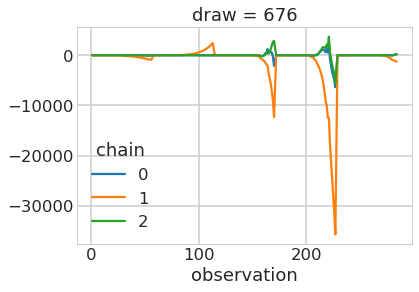

In [351]:
(tr.mu_confirmed - xr.DataArray(df_sign.confirmed, dims=('observation',))).isel(draw=-1).plot.line(x='observation')

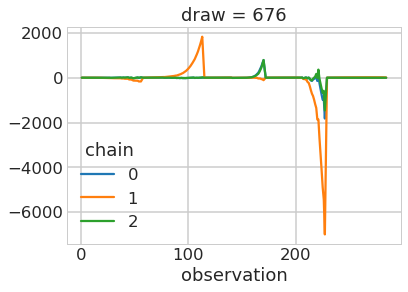

In [357]:
(tr.mu_recovered - xr.DataArray(df_sign.recovered + df_sign.deaths, dims=('observation',))).isel(draw=-1).plot.line(x='observation')

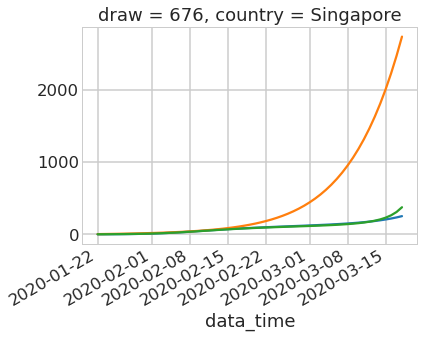

In [354]:
((1 - tr.solution_S) * xr.DataArray(countries['population'])).isel(country=1, draw=-1).plot.line(x='data_time', add_legend=False);

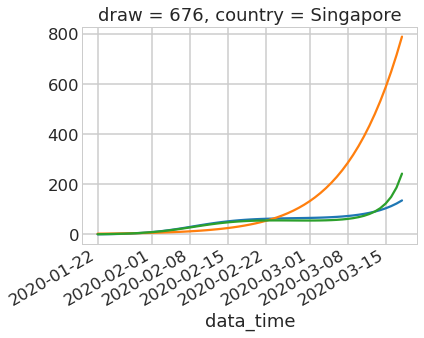

In [356]:
((tr.solution_I) * xr.DataArray(countries['population'])).isel(country=1, draw=-1).plot.line(x='data_time', add_legend=False);

In [430]:
#tr.solution_log_infection_rate

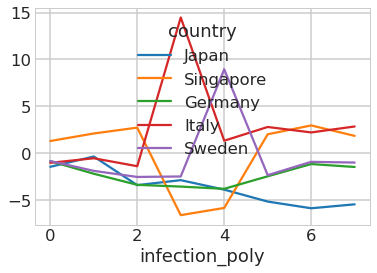

In [365]:
(
    (tr.infection_change_polys_sd * tr.infection_change_polys_raw)
    .cumsum('infection_poly')
    .median(['draw', 'chain'])
    .plot
    .line(x='infection_poly')
);

In [374]:
from scipy import interpolate

In [460]:
vals = (tr.infection_change_polys_raw * tr.infection_change_polys_sd / 100).transpose('infection_poly', ...).values
degree = 4
lower = 0
upper = len(tr.data_time)

n_knots = degree + len(vals) + 1
knots = np.arange(n_knots)
lower_knot = degree #+ lower * (n_knots - 2 * degree - 1)
upper_knot = degree + (n_knots - 2 * degree - 1)

knots = (knots - lower_knot) / (upper_knot - lower_knot)
knots = knots * (upper - lower) + lower

x = np.arange(upper)
spline = interpolate.BSpline(knots, vals.reshape((vals.shape[0], -1)), degree)
spline_int = spline.antiderivative()
infection_rate_change = (spline_int(x) - spline_int(lower)).reshape((upper, *vals.shape[1:]))

In [463]:
tr['infection_rate_change'] = (('data_time', *tr.infection_change_polys_raw.transpose('infection_poly', ...).dims[1:]), infection_rate_change)

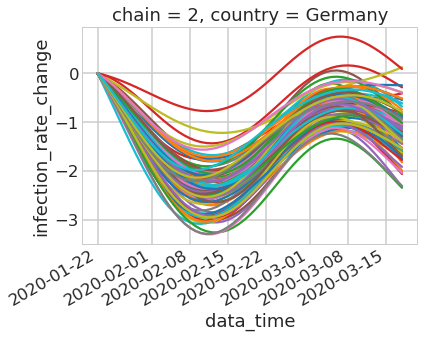

In [471]:
tr.infection_rate_change.sel(country='Germany', chain=2).isel(draw=slice(-100, None)).plot.line(x='data_time', add_legend=False);

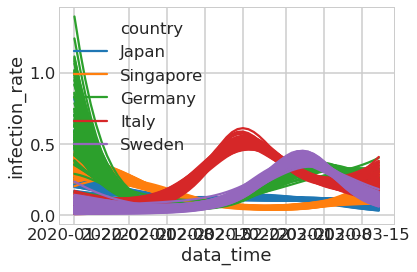

In [493]:
sns.lineplot(
    x='data_time',
    y='infection_rate',
    hue='country',
    units='draw',
    estimator=None,
    data = (
        np.exp(tr.solution_log_infection_rate)
        .rename('infection_rate')
        #.sel(country=['Germany', 'Japan'], chain=2)
        .sel(chain=2)
        .isel(draw=slice(-100, None))
        .to_dataframe()
        .reset_index()
    )
)

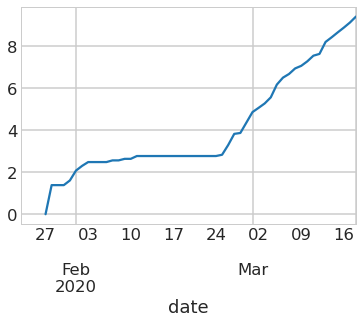

In [490]:
np.log(df_sign[df_sign.country == 'Germany'].set_index('date').confirmed).plot()

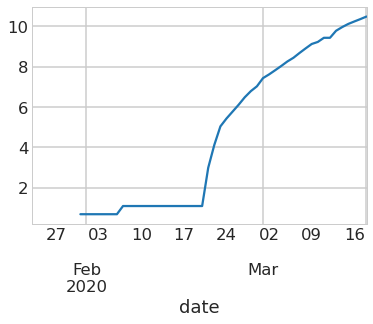

In [491]:
np.log(df_sign[df_sign.country == 'Italy'].set_index('date').confirmed).plot()

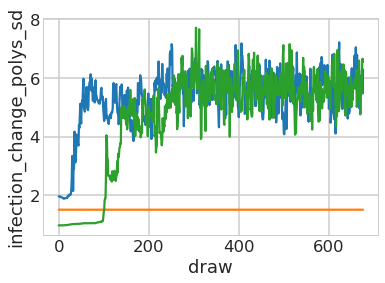

In [359]:
tr.infection_change_polys_sd.plot.line(x='draw', add_legend=False);

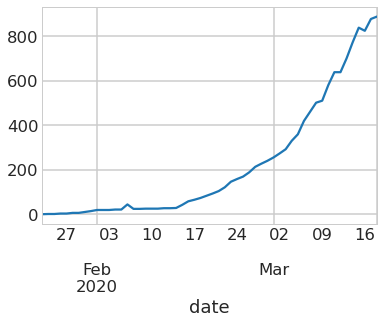

In [361]:
df_sign.query("country == 'Japan'").set_index('date').confirmed.plot()

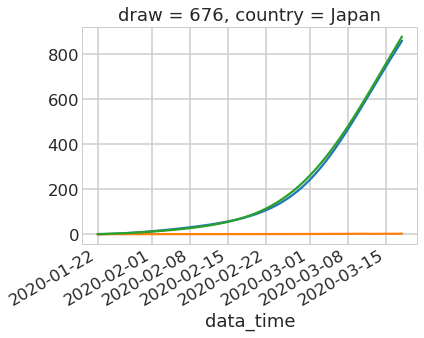

In [362]:
((1 - tr.solution_S) * xr.DataArray(countries['population'])).isel(country=0, draw=-1).plot.line(x='data_time', add_legend=False);

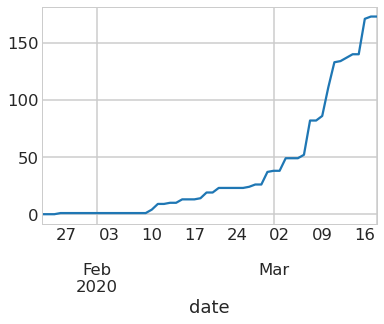

In [363]:
df_sign.query("country == 'Japan'").set_index('date').eval('recovered + deaths').plot()

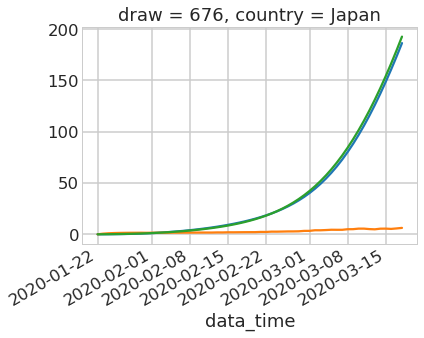

In [364]:
(tr.solution_R * xr.DataArray(countries['population'])).isel(country=0, draw=-1).plot.line(x='data_time', add_legend=False);

In [44]:
tr.solution_S.diff('data_time').max()

<xarray.DataArray 'solution_S' ()>
array(-2.27672892e-09)

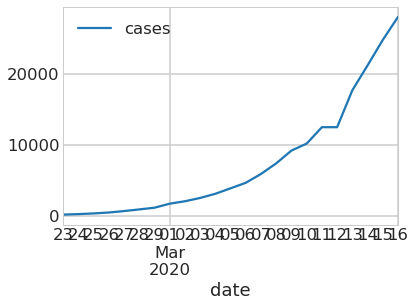

In [74]:
df_sign.plot.line(x='date', y='cases')